# Neural Color Transfer (Multi-Reference Style Transfer)

## Library

In [1]:
#Append 'src' direc to import modules from notebooks directory#
##################################################
#import os,sys
#src_dir=os.path.join(os.getcwd(),os.pardir)
#sys.path.append(src_dir)
#################################################

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib as plt
import time
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import cv2
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim
import scipy

## Input Source & Reference Image

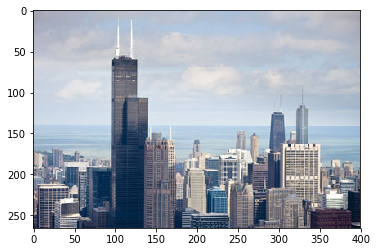

In [4]:
imgS_path = './image/city_basic.jpg'
imgR_path='./image/city_night.jpg'
imgS = Image.open(imgS_path).convert("RGB")
imshow(imgS)

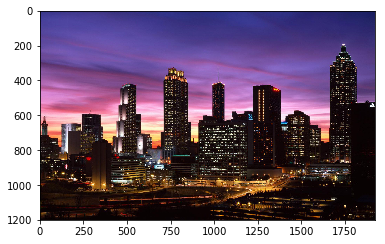

In [5]:
imgR = Image.open(imgR_path).convert("RGB")
imshow(imgR)

Image Loader

In [6]:
scale, tensorize, normalize = transforms.Scale((224,224)),transforms.ToTensor(),\
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    
loader = transforms.Compose([
    scale,tensorize,normalize
])

def image_loader(img_path,flip=False):
    img = Image.open(img_path).convert("RGB")
    if flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    image = loader(img)
    image = Variable(image.unsqueeze(0))
    
    return image

C:\Anaconda\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [7]:
imgS=image_loader(imgS_path,flip=False).float()
imgR=image_loader(imgR_path,flip=False).float()

imgS.data.size() #1,3,224,224
imgR.data.size()
imgS.data.dtype

torch.float32

In [8]:
def show(img):
    npimg = img.numpy()
    imshow(np.transpose(npimg, (1,2,0))) #,interpolation = 'nearest' )

## Process
From S_6 = S_L+1 to S_1(Final Result)

Feature Domain
    >FeatureExtractor
    >PatchMatch
    >BDS Voting

Image Domain
    >Resolution equal
    >Local Color Transfer

## FeatureExtractor

In [9]:
model1 = models.vgg19(pretrained=True).features
print(model1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [10]:
relu_1 = model1[1] #1,6,11,20,29
relu_2 = model1[6]
relu_3 = model1[11]
relu_4 = model1[20]
relu_5 = model1[29]

print(relu_1)
print(relu_2)

ReLU(inplace)
ReLU(inplace)


In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self,name, layer):
        self.add_module(name, layer)
    
    def forward(self,x):
        list = []
        for module in self._modules:
            x = self._modules[module](x)
            list.append(x)
        return list


model_t  =  FeatureExtractor()  # the new Feature extractor module network
i = 1
conv_counter = 1
relu_counter = 1
pool_counter = 1
batn_counter = 1

block_counter = 1

for layer in list(model1):
    
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_"+str(conv_counter)
        conv_counter +=1
        model_t.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_"+str(relu_counter)
        relu_counter +=1
        model_t.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        pool_counter = bn_counter = relu_counter = conv_counter= 1
        block_counter +=1
        model_t.add_layer(name, nn.AvgPool2d((2,2)))  # ***
        
    if isinstance(layer, nn.BatchNorm2d):
        name = "batn_" + str(block_counter) + "_"+str(batn_counter)
        batn_counter +=1

In [12]:
model_t

FeatureExtractor(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU(inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU(inplace)
  (pool_1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU(inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU(inplace)
  (pool_2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU(inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU(inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU(inplace)
  (conv_3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [13]:
reS =torch.squeeze(model_t(imgS.data)[-7]).data #into layer
print(reS.size()) #512,14,14
rsS = reS.view(-1,1,reS.size()[1],reS.size()[2]).data #resized
print(rsS.size()) #512 1 14 14

torch.Size([512, 14, 14])
torch.Size([512, 1, 14, 14])


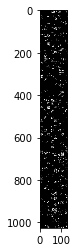

In [14]:
show(make_grid(rsS))

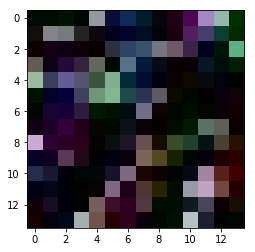

In [15]:
reSnp = reS.numpy().transpose(1,2,0)
reSnpImg = Image.fromarray(reSnp,'RGB')
reSnpImg.save('processImage/reSnpImg.jpg')
reSnpImg = imread('processImage/reSnpImg.jpg')
imshow(reSnpImg)

In [16]:
reR =torch.squeeze(model_t(imgR.data)[-7]).data #into layer
print(reR.size()) #512,14,14
rsR = reS.view(-1,1,reS.size()[1],reR.size()[2]).data #resized
print(rsR.size()) #512 1 14 14

torch.Size([512, 14, 14])
torch.Size([512, 1, 14, 14])


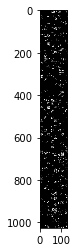

In [17]:
show(make_grid(rsR))

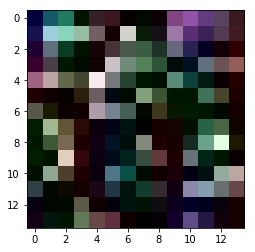

In [18]:
reRnp = reR.numpy().transpose(1,2,0)
reRnpImg = Image.fromarray(reRnp,'RGB')
reRnpImg.save('processImage/reRnpImg.jpg')
reRnpImg = imread('processImage/reRnpImg.jpg')
imshow(reRnpImg)

## PatchMatch

In [19]:
class PatchMatch: 
    def __init__(self, a, b, patchsize=3):
        self.a = a
        self.a_height = self.a.shape[1]    #C * H * W (e.g. 3 * 224 * 224)
        self.a_width = self.a.shape[2]
        self.b = b
        self.b_height = self.b.shape[1]
        self.b_width = self.b.shape[2]
        self.patchsize = patchsize
        self.channels = self.a.shape[0]

        self.aew = self.a.shape[2] - self.patchsize + 1 #number of patch that can be made in width
        self.aeh = self.a.shape[1] - self.patchsize + 1 #number of patch that can be made in height
        self.bew = self.b.shape[2] - self.patchsize + 1
        self.beh = self.b.shape[1] - self.patchsize + 1
        self.nnf = np.zeros((self.a.shape[1], self.a.shape[2], 2)).astype(np.int) #nnf build
        self.nnd = np.zeros((self.a.shape[1], self.a.shape[2])) #nnf distance
        self.init_nnf()

    def init_nnf(self):
        for ay in range(0, self.aeh):
            for ax in range(0, self.aew):
                bx = np.random.randint(0, self.bew - 1)
                by = np.random.randint(0, self.beh - 1)
                self.nnf[ay, ax, :] = [bx, by]
                self.nnd[ay, ax] = self.calc_dist(ax, ay, bx, by)

    def calc_dist(self, ax, ay, bx, by, cutoff = 2147483647):
        """
        Measures distance between 2 patches across all channels
        ax -- x coordinate of patch a
        ay -- y coordinate of patch a
        bx -- x coordinate of patch b
        by -- y coordinate of patch b
        cutoff
        """
        num_pixels = 0
        pixel_sum = 0
        dmax = self.patchsize // 2  # dmax = 1
        for dy in range(-dmax, dmax): #from middle pixel in patch -1~+1 
            for dx in range(-dmax, dmax):
                pixel_exists_in_a = (ay + dy) < self.a_height and (ay + dy) >= 0 and (ax + dx) < self.a_width and (ax + dx) >= 0
                pixel_exists_in_b = (by + dy) < self.b_height and (by + dy) >= 0 and (bx + dx) < self.b_width and (bx + dx) >= 0
                if pixel_exists_in_a and pixel_exists_in_b:
                    for dc in range(0, self.channels):
                        dp_tmp = self.a[dc, ay + dy, ax + dx] - self.b[dc, by + dy, bx + dx]
                        pixel_sum += (dp_tmp*dp_tmp)

                num_pixels += 1
        ans = num_pixels / pixel_sum
        if ans >= cutoff: return cutoff
        return ans

    def improve_guess(self, ax, ay, xbest, ybest, dbest, bx, by):
        d = self.calc_dist(ax, ay, bx, by, dbest)
        if d < dbest:
            dbest = d
            xbest = bx
            ybest = by
        return xbest, ybest, dbest

    def improve_nnf(self, total_iter=5):
        for iter in range(total_iter):
            print(iter)
            ystart, yend, ychange = 0, self.aeh, 1
            xstart, xend, xchange = 0, self.aew, 1
            if iter % 2 == 1:
                ystart, yend, ychange = yend-1, -1, -1
                xstart, xend, xchange = xend-1, -1, -1
            for ay in range(ystart, yend, ychange):
                for ax in range(xstart, xend, xchange):
                    # best guess
                    xbest, ybest = self.nnf[ay, ax]
                    dbest = self.nnd[ybest, xbest]

                    # propagation

                    if 0 < ax - xchange < self.aew:
                        xp, yp = self.nnf[ay, ax-xchange]
                        if 0 < xp < self.bew:
                            xbest, ybest, dbest = self.improve_guess(ax, ay, xbest, ybest, dbest, xp, yp)
                    if 0 < ay - ychange < self.aeh:
                        xp, yp = self.nnf[ay-ychange, ax]
                        yp += ychange
                        if 0 < yp < self.beh:
                            xbest, ybest, dbest = self.improve_guess(ax, ay, xbest, ybest, dbest, xp, yp)

                    # random search

                    mag = max(self.b.shape[1], self.b.shape[2])

                    while mag >= 1:
                        xmin, xmax = max(xbest-mag, 0), min(xbest+mag+1, self.bew)
                        ymin, ymax = max(ybest-mag, 0), min(ybest+mag+1, self.beh)
                        xp = np.random.randint(xmin, xmax)
                        yp = np.random.randint(ymin, ymax)
                        xbest, ybest, dbest = self.improve_guess(ax, ay, xbest, ybest, dbest, xp, yp)
                        mag = mag // 2

                    self.nnf[ay, ax, :] = [xbest, ybest]
                    self.nnd[ay, ax] = dbest

    def solve(self):
        self.improve_nnf(total_iter=5)

## BDS Voting (Reconstruct)

In [20]:
def bds_vote(snn, rnn, snnd, rnnd, src, patchsize=3):
    """
    Reconstructs an image or feature map by bidirectionaly
    similarity voting
    """

    src_height = src.shape[1]
    src_width = src.shape[2]
    channels = src.shape[0]

    dest = np.zeros(src.shape)

    dest_height = src.shape[1]
    dest_width = src.shape[2]

    pmax = patchsize // 2

    weights = np.zeros((dest_height, dest_width))

    print(snn.shape)
    ws = 1 / ((snn.shape[1] - patchsize + 1) * (snn.shape[2] - patchsize + 1))
    wr = 1 / ((rnn.shape[1] - patchsize + 1) * (rnn.shape[2] - patchsize + 1))
    # coherence
    # The S->R forward NNF enforces coherence
    for i in range(src_width):
        for j in range(src_height):

            px = snn[0, i, j]
            py = snn[1, i, j]

            for dy in range(j-pmax, j+pmax):
                if j + dy < 0:
                    continue
                if j + dy >= dest_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= src_height:
                    break
                for dx in range(i-pmax, i+pmax):
                    if i + dx < 0:
                        continue
                    if i + dx >= dest_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= src_width:
                        break
                    for ch in range(channels):
                        dest[ch, dy + j, dx + i] += ws * src[ch, py + dy, px + dx]
                    weights[dy + j, dx + i] += ws


    # completeness
    # The R->S backward NNF enforces completeness
    for i in range(src_width):
        for j in range(src_height):

            px = rnn[0, i, j]
            py = rnn[1, i, j]

            for dy in range(j-pmax, j+pmax):
                if j + dy < 0:
                    continue
                if j + dy >= src_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= dest_height:
                    break
                for dx in range(i-pmax, i+pmax):
                    if i + dx < 0:
                        continue
                    if i + dx >= src_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= dest_width:
                        break
                    for ch in range(channels):
                        dest[ch, py + dy, px + dx] += wr * src[ch, dy + j, dx + i]
                    weights[py + dy, px + dx] += wr

    for x in range(dest_width):
        for y in range(dest_height):
            s = 1 if weights[y, x] == 0 else (1 / weights[y, x])
            for ch in range(channels):
                dest[ch, y, x] *= s

    return dest

In [21]:
snn = PatchMatch(reS.numpy(),reR.numpy()) #S->R
snn.solve()

0
1
2
3
4


In [22]:
rnn = PatchMatch(reR.numpy(),reS.numpy()) #R->S
rnn.solve()

0
1
2
3
4


In [32]:
def _resized_R(self, size):
        return utils.image_to_tensor(self.style_image, [transforms.Resize(size)])

In [40]:
Rs_R = imgR.resize_as_(reR)
G = bds_vote(snn.nnf.transpose(2,1,0), rnn.nnf.transpose(2,1,0), snn.nnd.transpose(1,0), rnn.nnd.transpose(1,0),Rs_R)
print(G)

(2, 14, 14)
[[[-1.19316729 -1.19744849 -1.33016538 ..., -1.35299837 -1.34729012
   -1.34729012]
  [-1.21885447 -1.22313558 -1.36441477 ..., -1.36441483 -1.34729007
   -1.36013366]
  [-1.25738515 -1.25738515 -1.36013366 ..., -1.4157891  -1.40294556
   -1.33701524]
  ..., 
  [-1.39438314 -1.39866434 -1.35585251 ..., -1.28034785 -1.31699243
   -1.34300889]
  [-1.34729007 -1.36441486 -1.3529983  ..., -1.36441485 -1.38417416
   -1.39207788]
  [-1.41578903 -1.43291382 -1.44433038 ..., -1.33995089 -1.3572795
   -1.36046296]]

 [[-1.27450989 -1.27450989 -1.16748018 ..., -1.25595809 -1.29163465
   -1.29591585]
  [-1.27879104 -1.29163463 -1.21029206 ..., -1.2959158  -1.32588411
   -1.31732177]
  [-1.21029203 -1.20601081 -1.28307228 ..., -1.28735346 -1.27450991
   -1.24111664]
  ..., 
  [-1.27879106 -1.29163461 -1.29163461 ..., -1.18071292 -1.20502288
   -1.23597917]
  [-1.32160289 -1.33016538 -1.3472901  ..., -1.25096334 -1.29064668
   -1.30777144]
  [-1.27879111 -1.2959158  -1.34158184 ..., -1.

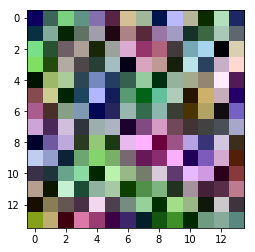

In [41]:
npG=G.transpose(1,2,0)
imgG =Image.fromarray(npG,'RGB')
imgG.save('processImage/imgG.jpg')
imgG=imread('processImage/imgG.jpg')
imshow(imgG)